In [1]:
import datetime as dt
from datetime import datetime
from datetime import time
from datetime import date
import time as tm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image  # 在cell中显示图片

In [2]:
# 读入测试数据
dfAAPL = pd.read_csv("quote_nasdaq_aapl_m1_2011_onetick_ntc.csv")

# 取测试数据的前100行作为实验数据
dfSrc = dfAAPL[100:300]     # df11=实验源数据
dfSrc = dfSrc.set_index(np.arange(0,len(dfSrc),1,dtype=np.int64))
print 'dfSrc: len=',len(dfSrc)
print 'top 5 of dfSrc:\n',dfSrc.head()

dfSrc: len= 200
top 5 of dfSrc:
         DATE  TIME            TIMESTAMP    OPEN    HIGH     LOW   CLOSE  \
0  01/03/2011  1110  1294024200000012345  329.54  329.57  329.42  329.50   
1  01/03/2011  1111  1294024260000012345  329.50  329.55  329.26  329.30   
2  01/03/2011  1112  1294024320000012345  329.31  329.47  329.29  329.31   
3  01/03/2011  1113  1294024380000012345  329.31  329.48  329.27  329.34   
4  01/03/2011  1114  1294024440000012345  329.35  329.50  329.32  329.43   

   VOLUME  
0   45706  
1   42324  
2   46865  
3   22190  
4   23535  


In [3]:
#---------------------------
# <Step-1>生成3个key column

# Key by Hours
seKeyH = pd.Series(np.int64(dfSrc['TIME']/100))  # Buckets created by Hours
seKeyH.name = 'KeyH'
print 'top 5 of KyeH:\n',seKeyH.head(),'\n'

# Key by OPEN/CLOSE
seKeyP = dfSrc['CLOSE']/dfSrc['OPEN']  # X=CLOSE/OPEN
seKeyP[seKeyP >= 1.0002] = 3
seKeyP[seKeyP <1.0 ] = 2
seKeyP[seKeyP < 2] = 1
seKeyP[seKeyP == 3] = 'P+' # P+: 1.0002<=X
seKeyP[seKeyP == 2] = 'P'  # P:  1.0=<X<=1.0002
seKeyP[seKeyP == 1] = 'P-' # P-: X<1.0
seKeyP.name = 'KeyP'
print 'top 5 of KyeP:\n',seKeyP.head(),'\n'

# key by Volume
seKeyV = dfSrc['VOLUME'] - np.int64(dfSrc['VOLUME'].mean())  # X = Vol - Vol.mean
seKeyV[seKeyV >= 0] = 'V+'  # V+: X>=0
seKeyV[seKeyV < 0] = 'V-'   # V-: X<0
seKeyV.name='KeyV'
print 'top 5 of KyeV:\n',seKeyV.head(),'\n'


top 5 of KyeH:
0    11
1    11
2    11
3    11
4    11
Name: KeyH, dtype: int64 

top 5 of KyeP:
0     P
1     P
2    P-
3    P-
4    P+
Name: KeyP, dtype: object 

top 5 of KyeV:
0    V+
1    V+
2    V+
3    V+
4    V+
Name: KeyV, dtype: object 



In [4]:
#-----------------------------------------
# <Step-2> 添加生成的3个Key columns到dfTest

dfTest = dfSrc.join(seKeyH).join(seKeyP).join(seKeyV)
print 'top 5 of dfTest:\n',dfTest.head()

top 5 of dfTest:
         DATE  TIME            TIMESTAMP    OPEN    HIGH     LOW   CLOSE  \
0  01/03/2011  1110  1294024200000012345  329.54  329.57  329.42  329.50   
1  01/03/2011  1111  1294024260000012345  329.50  329.55  329.26  329.30   
2  01/03/2011  1112  1294024320000012345  329.31  329.47  329.29  329.31   
3  01/03/2011  1113  1294024380000012345  329.31  329.48  329.27  329.34   
4  01/03/2011  1114  1294024440000012345  329.35  329.50  329.32  329.43   

   VOLUME  KeyH KeyP KeyV  
0   45706    11    P   V+  
1   42324    11    P   V+  
2   46865    11   P-   V+  
3   22190    11   P-   V+  
4   23535    11   P+   V+  


In [5]:
#-----------------------------------------
# <Step-3> 
# 用上面生成的3个Keys对dfTest进行GroupBy操作
# 生成dfTest的groupby对象gpTest

gpTest = dfTest.groupby(['KeyH','KeyP','KeyV'])
print 'type(gpTest) = ',type(gpTest)

type(gpTest) =  <class 'pandas.core.groupby.DataFrameGroupBy'>


In [6]:
#---------------
# 实验-1
#---------------
# CLOSE.count() by stacked keys: keyH,KeyP,KeyV

dfCloseA = pd.DataFrame(gpTest.CLOSE.count())   #输出count of CLOSE
print dfCloseA

                CLOSE
KeyH KeyP KeyV       
11   P    V+       15
          V-        5
     P+   V+       12
          V-        3
     P-   V+       10
          V-        5
12   P    V+        7
          V-       19
     P+   V+        3
          V-        4
     P-   V+        4
          V-       23
13   P    V+        3
          V-       19
     P+   V-        6
     P-   V+        6
          V-       26
14   P    V+        8
          V-        9
     P+   V+        4
          V-        1
     P-   V+        3
          V-        5


In [7]:
# 绘图输出 dfCloseA
dfCloseA.plot(kind='bar',stacked=True)
plt.show()

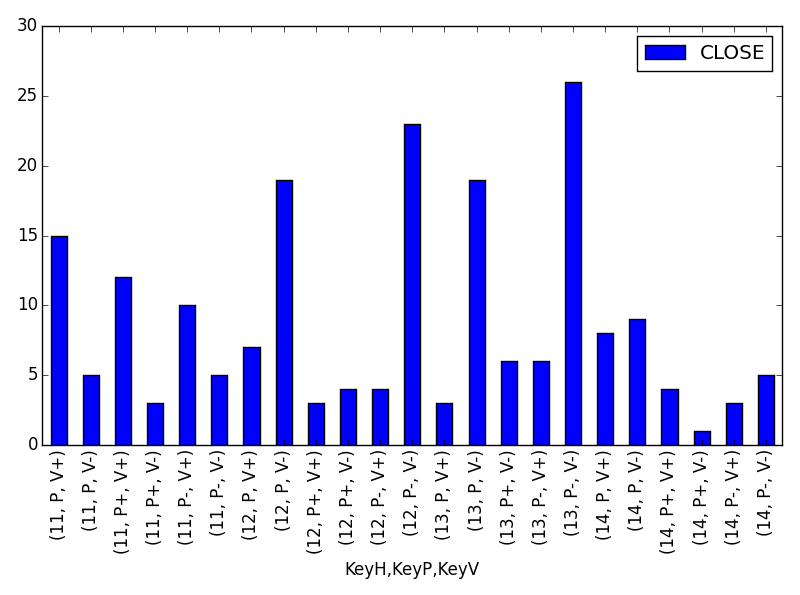

In [8]:
Image(filename='figure_closea.png')

In [9]:
#---------------
# 实验-2
#---------------
# CLOSE.count() by stacked keys: KeyH,KeyV
# keyV is unstacked (row -> col)

dfCloseB = gpTest.CLOSE.count().unstack(['KeyP'])  # unstack keyP
print dfCloseB

KeyP        P  P+  P-
KeyH KeyV            
11   V+    15  12  10
     V-     5   3   5
12   V+     7   3   4
     V-    19   4  23
13   V+     3 NaN   6
     V-    19   6  26
14   V+     8   4   3
     V-     9   1   5


In [26]:
# 绘图输出 dfCloseB
dfCloseB.plot(kind='bar',stacked=True)
# dfCloseB.plot(kind='bar',stacked=False)

plt.show()

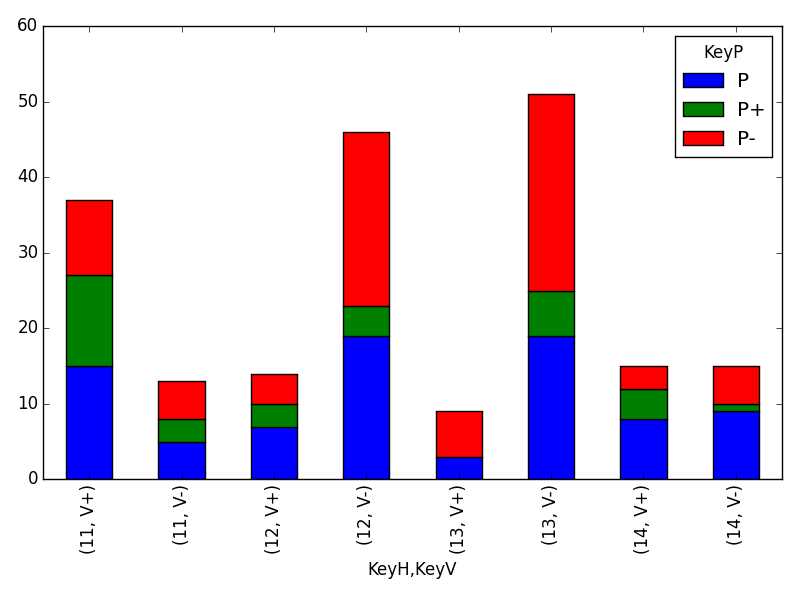

In [11]:
Image(filename='figure_closeb.png')

In [12]:
#---------------
# 实验-3
#---------------
# CLOSE.count() ONLY by key: KeyH
# keyP/keyV are unstacked (rows -> cols)

dfCloseC = gpTest.CLOSE.count().unstack(['KeyP','KeyV'])  # unstack KeyP/KeyV
print dfCloseC

KeyP   P      P+     P-    
KeyV  V+  V-  V+ V-  V+  V-
KeyH                       
11    15   5  12  3  10   5
12     7  19   3  4   4  23
13     3  19 NaN  6   6  26
14     8   9   4  1   3   5


In [13]:
# 绘图输出 dfCloseC
dfCloseC.plot(kind='bar',stacked=True)
plt.show()

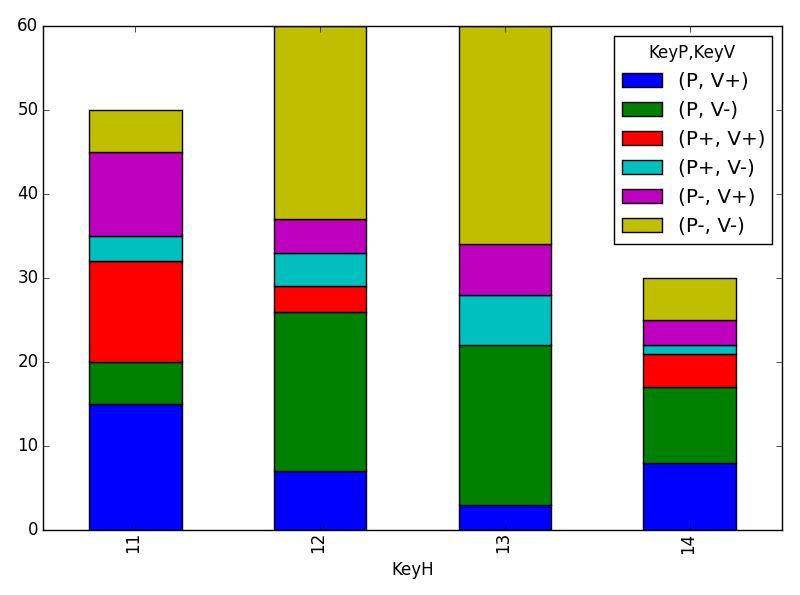

In [14]:
Image(filename='figure_closec.png')

In [15]:
#---------------
# 实验-4
#---------------
# 只用KeyH/KeyP两组key对dfTest进行groupby

gpTest2 = dfTest.groupby(['KeyH','KeyP'])

In [16]:
#---------------
# 实验-4.1
#---------------
# 直接显示

dfCloseA2 = pd.DataFrame(gpTest2.CLOSE.count())   #输出count of CLOSE
print dfCloseA2

           CLOSE
KeyH KeyP       
11   P        20
     P+       15
     P-       15
12   P        26
     P+        7
     P-       27
13   P        22
     P+        6
     P-       32
14   P        17
     P+        5
     P-        8


In [17]:
dfCloseA2.plot(kind='bar',stacked=True)
plt.show()

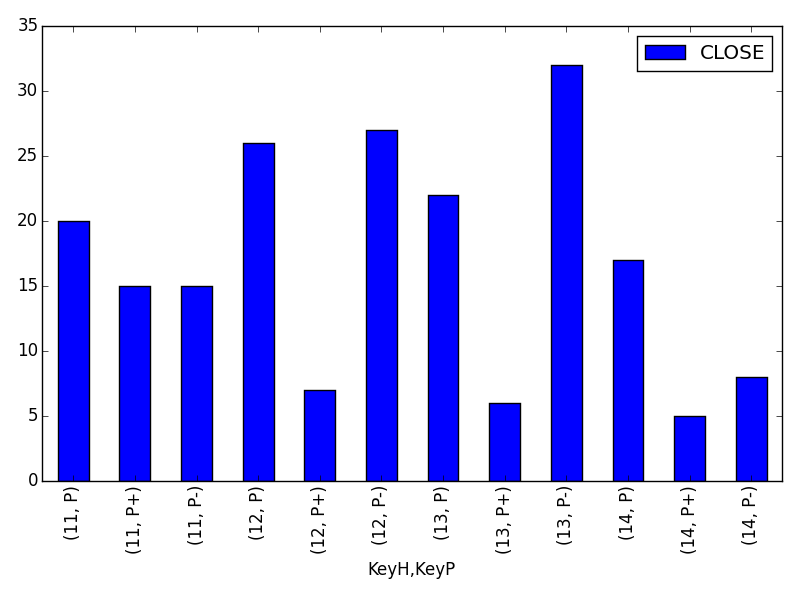

In [18]:
Image(filename='figure_closea2.png')

In [19]:
#---------------
# 实验-4.2
#---------------
# unstack KeyP

dfCloseC2 = gpTest2.CLOSE.count().unstack(['KeyP'])  # unstack KeyP
print dfCloseC2

KeyP   P  P+  P-
KeyH            
11    20  15  15
12    26   7  27
13    22   6  32
14    17   5   8


In [20]:
dfCloseC2.plot(kind='bar',stacked=True)
plt.show()

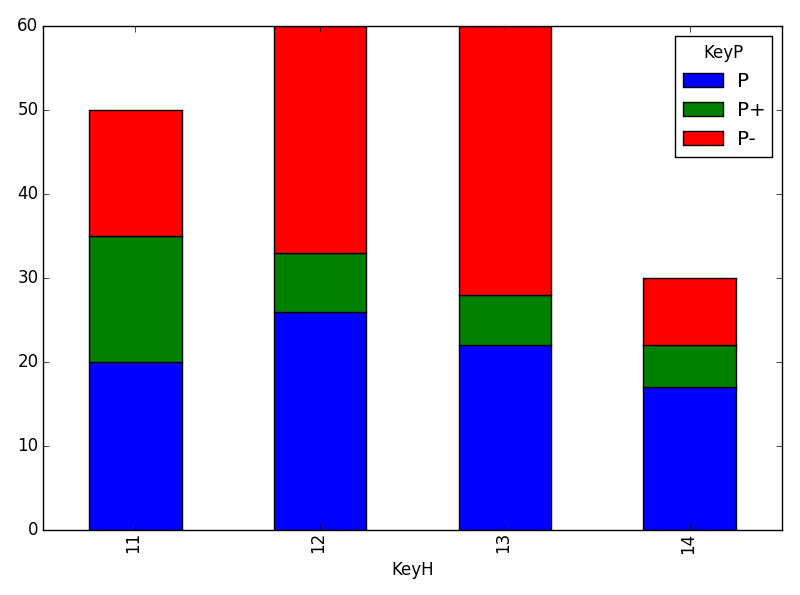

In [21]:
Image(filename='figure_closec2.png')

In [22]:
#---------------
# 实验-5
#---------------
# 计算输出结果DF的寻址(多重index)

dfCloseC = gpTest.CLOSE.count().unstack(['KeyP','KeyV'])  # unstack KeyP/KeyV
print 'dfCloseC:\n',dfCloseC
print

#Row=2,Col=1
print '[row=2,col=1] by iloc[1,0] = ',dfCloseC.iloc[1,0]  
print '[row=2,col=1] by ix[12,0] = ',dfCloseC.ix[12,0]

dfCloseC:
KeyP   P      P+     P-    
KeyV  V+  V-  V+ V-  V+  V-
KeyH                       
11    15   5  12  3  10   5
12     7  19   3  4   4  23
13     3  19 NaN  6   6  26
14     8   9   4  1   3   5

[row=2,col=1] by iloc[1,0] =  7.0
[row=2,col=1] by ix[12,0] =  7.0


In [23]:
#---------------
# 实验-6
#---------------
# Fill NaN

print 'INPUT = dfCloseC:\n',dfCloseC    # dfCloseC 做为测试DF
print

# 方法-1: fillna并赋值
dfCloseX = dfCloseC.copy()              # dfCloseX=dfCloseC的副本，用于测试
dfCloseX = dfCloseX.fillna(value=0)
print 'OUTPUT1 = dfCloseX:\n',dfCloseX
print

# 方法-2: fillna并修改原DF
dfCloseX = dfCloseC.copy()              # dfCloseX=dfCloseC的副本，用于测试
dfCloseX.fillna(value=0,inplace=True)
print 'OUTPUT2 = dfCloseX:\n',dfCloseX
print

INPUT = dfCloseC:
KeyP   P      P+     P-    
KeyV  V+  V-  V+ V-  V+  V-
KeyH                       
11    15   5  12  3  10   5
12     7  19   3  4   4  23
13     3  19 NaN  6   6  26
14     8   9   4  1   3   5

OUTPUT1 = dfCloseX:
KeyP   P      P+     P-    
KeyV  V+  V-  V+ V-  V+  V-
KeyH                       
11    15   5  12  3  10   5
12     7  19   3  4   4  23
13     3  19   0  6   6  26
14     8   9   4  1   3   5

OUTPUT2 = dfCloseX:
KeyP   P      P+     P-    
KeyV  V+  V-  V+ V-  V+  V-
KeyH                       
11    15   5  12  3  10   5
12     7  19   3  4   4  23
13     3  19   0  6   6  26
14     8   9   4  1   3   5



In [24]:
#---------------
# 实验-7
#---------------
# 多重索引的排序

dfCloseA2 = dfCloseA.copy()
print 'Before sorting:\n',dfCloseA2
dfCloseA2 = dfCloseA2.unstack(['KeyP','KeyV'])
print 'unstacked:\n',dfCloseA2
print

dfCloseA2 = dfCloseA.copy()
dfCloseA2.sortlevel(level=1,ascending=False,sort_remaining=False,inplace=True) #按KeyP降序
print 'After sorting:\n',dfCloseA2
dfCloseA2 = dfCloseA2.unstack(['KeyP','KeyV'])
print 'unstacked:\n',dfCloseA2

Before sorting:
                CLOSE
KeyH KeyP KeyV       
11   P    V+       15
          V-        5
     P+   V+       12
          V-        3
     P-   V+       10
          V-        5
12   P    V+        7
          V-       19
     P+   V+        3
          V-        4
     P-   V+        4
          V-       23
13   P    V+        3
          V-       19
     P+   V-        6
     P-   V+        6
          V-       26
14   P    V+        8
          V-        9
     P+   V+        4
          V-        1
     P-   V+        3
          V-        5
unstacked:
     CLOSE                   
KeyP     P      P+     P-    
KeyV    V+  V-  V+ V-  V+  V-
KeyH                         
11      15   5  12  3  10   5
12       7  19   3  4   4  23
13       3  19 NaN  6   6  26
14       8   9   4  1   3   5

After sorting:
                CLOSE
KeyH KeyP KeyV       
14   P-   V-        5
          V+        3
13   P-   V-       26
          V+        6
12   P-   V-       23
          V+ 